In [25]:
# import modules
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import h5py
plt.style.use('default')
import re

In [26]:

def read_cbd(file_path):
    '''
    read_cbd: reads the cbd file data
    Arguments:
    file_path-- path where the file is located
    Return--
    xr_data-- data_matrix: 3-D matrix of size (N_x, N_y, N_z)
          x-coord: 1-D array of  x-coordinates size (N_x,1)
          y-coord: 1-D array of  y-coordinates size (N_y,1)
          z-coord: 1-D array of  z-coordinates size (N_z,1)
    '''
    f = open(file_path, "rb")
    id = np.fromfile(f, dtype=np.int64, count=1)[0]
    if id == 288230376151834571:
        T = np.float32
    elif id == 576460752303546315:
        T = np.float64
    else:
        raise ValueError("Invalid ID")
    N = tuple(np.fromfile(f, dtype=np.int64, count=3))
    xmin = tuple(np.fromfile(f, dtype=np.float64, count=3))
    xmax = tuple(np.fromfile(f, dtype=np.float64, count=3))
    x1, x2, x3 = (np.fromfile(f, dtype=np.float64, count=n) for n in N)
    data1 = np.fromfile(f, dtype=T, count=np.prod(N)).reshape(N, order="F")
    #dic = {"data":data1, "x-coord":x1, "y-coord":x2, "z-coord":x3, "diagonal_points":[xmin,xmax]}
    xr_data = xr.DataArray(
        data1,
        dims = ("x", "y", "z"),
        coords = { "x" : x1,
                  "y" : x2,
                  "z" : x3
        }   
    )
    f.close()
    return xr_data

def h5_in_xarray(field):
    #hf = h5py.File(filepath, 'r')
    data = hf.get('%s' % field)
    x1 = hf.get('x-coord')
    x2 = hf.get('y-coord')
    x3 = hf.get('z-coord')
    xr_data = xr.DataArray(
        np.array(data),
        dims = ("x", "y", "z"),
        coords = { "x" : np.array(x1),
                  "y" : np.array(x2),
                  "z" : np.array(x3)
        }   
    )
    
    return xr_data

def create_xarray(u):
    
    # This function creates an xarray that has same data size and coordinates aligned with the input xarray u
    new_array = xr.DataArray(
        np.empty(u.shape),
        dims = ("x", "y", "z"),
        coords = { "x" : u['x'],
              "y" : u['y'],
              "z" : u['z']
        }
    )
    
    return new_array

### Loading the data

In [27]:
filepath = "/home/as2204/TACC_postprocess/grid_reso_analysis"
sim_list = os.listdir(filepath)
sim_list = [match for match in sim_list if "chan_" in match]
f = {}
field_list = ['u', 'v', 'w', 'uu', 'uv', 'uw', 'vv', 'vw', 'ww']

for sim in sim_list:
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    for field in field_list:
        f['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

In [28]:
var_list = ['uu', 'uv', 'uw', 'vv', 'vw', 'ww']
temp = {}

for sim in sim_list:
    for v in var_list:
        temp["%s%s" % (v, sim[4:-3])] = f["%s%s" % (v, sim[4:-3])].mean(dim = ['x', 'y']) - (f["%s%s" % (v[0], sim[4:-3])] * f["%s%s" % (v[1], sim[4:-3])]).mean(dim = ['x', 'y'])

disp = {}

for sim in sim_list:
    for v in var_list:
        disp["%s%s" % (v, sim[4:-3])] = (f["%s%s" % (v[0], sim[4:-3])]*f["%s%s" % (v[1], sim[4:-3])]).mean(dim = ['x', 'y']) - f["%s%s" % (v[0], sim[4:-3])].mean(dim = ['x', 'y']) * f["%s%s" % (v[1], sim[4:-3])].mean(dim = ['x', 'y'])

# calculating total stress
stress = {}

for sim in sim_list:
    for v in var_list:
        stress["%s%s" % (v, sim[4:-3])] = temp["%s%s" % (v, sim[4:-3])] + disp["%s%s" % (v, sim[4:-3])]

### Figure 14

['u_l6_4x12x24_4x4x8', 'u_l6_4x12x24_6x6x12', 'u_l6_4x12x24_8x8x16']
['u_l6_4x12x24_4x4x8', 'u_l6_4x12x24_6x6x12', 'u_l6_4x12x24_8x8x16']
['u_l6_4x12x24_4x4x8', 'u_l6_4x12x24_6x6x12', 'u_l6_4x12x24_8x8x16']


Text(0.077, 0.5, '$x_3/h$')

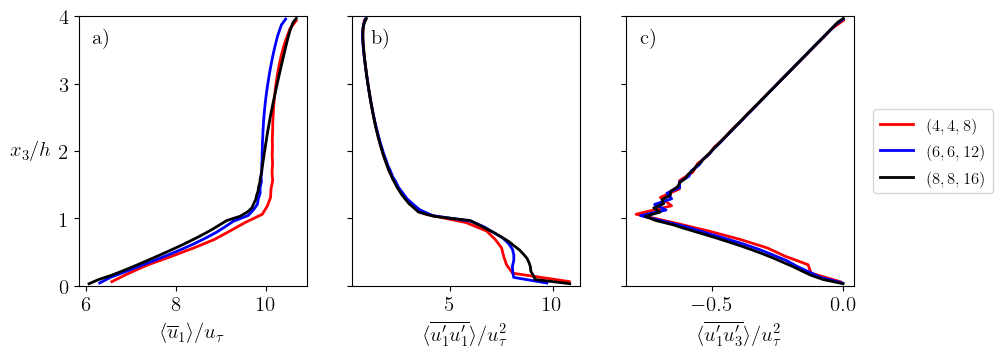

In [29]:
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)

fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), sharey=True)

pack_den = "l6"
stats_list = ['u', 'uu', 'uw']
for index, stat in enumerate(stats_list):   
    key_list = list(f.keys())
    key_list = [match for match in key_list if pack_den in match and match.startswith("u_")]

    key_list.sort()
    print(key_list)
    namelist = ['a)', 'b)', 'c)']
    clist = ['r', 'b', 'k']
    for index1, key in enumerate(key_list):
        reso = re.search('.*_(\d+)x(\d+)x(\d+)', key)
        reso = (reso.group(3), reso.group(2), reso.group(1))
        if len(stat) == 2:
            axs[index].plot(stress['%s%s' % (stat, key[1:])], f['%s%s' % (stat, key[1:])]['z'], clist[index1], linewidth=2, label=r'$(%s, %s, %s)$' % (reso[2], reso[1], reso[0]))
        else:
            axs[index].plot(f['%s%s' % (stat, key[1:])].mean(dim=['x', 'y']), f['%s%s' % (stat, key[1:])]['z'], clist[index1], linewidth=2, label=r'$(N_1, N_2, N_3) = (%s, %s, %s)$' % (reso[2], reso[1], reso[0]))
    if index==1:
        plt.text(0.125, 0.9, namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    else:
        plt.text(0.1, 0.9, namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 4)
axs[2].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)
axs[0].set_xlabel(r'$\langle\overline{u}_1\rangle/u_\tau$', fontsize=15, labelpad=5)
axs[1].set_xlabel(r'$\langle\overline{u_1^\prime u_1^\prime}\rangle/u_\tau^2$', fontsize=15, labelpad=5)
axs[2].set_xlabel(r'$\langle\overline{u_1^\prime u_3^\prime}\rangle/u_\tau^2$', fontsize=15, labelpad=5)
fig1.text(0.077, 0.5, r'$x_3/h$', ha='center', va='center', rotation='horizontal', fontsize=15)

In [30]:
# Computing errors for the plot above
from tabulate import tabulate
from numpy.linalg import norm

def project_to_delta16(ddelta, d16):
    n = d16.size
    z_grid = np.linspace(ddelta['z'][0], ddelta['z'][-1], n)
    vel_intp = ddelta.interp(z = z_grid)
    return vel_intp

def compute_norms_domhimpact(pack_den):
    key_list = list(f.keys())
    key_list = [match for match in key_list if pack_den in match and match.startswith("u_")]
    key_list.sort()
    print(key_list)

    truth = f["%s" % key_list[-1]].mean(dim = ['x', 'y'])
    norms = [[], [], []]
    for index, key in enumerate(key_list[:-1]):
        norms[index].append(key)
        val = f["%s" % key].mean(dim = ['x', 'y'])
        val_intp = project_to_delta16(val, truth)
        error = val_intp.values - truth.values
        l2 = norm(error, ord=2) / norm(truth.values, ord=2)
        norms[index].append("%.4f" % l2)

    print(tabulate(norms, headers=["key", "error"]))
    return None

def compute_norms_domhimpact_stress(pack_den, var):
    key_list = list(f.keys())
    key_list = [match for match in key_list if pack_den in match and match.startswith("u_")]
    key_list.sort()
    print(key_list)

    truth = stress["%s%s" % (var, key_list[-1][1:])]
    norms = [[], [], []]
    for index, key in enumerate(key_list[:-1]):
        norms[index].append(key)
        val = stress["%s%s" % (var, key[1:])]
        val_intp = project_to_delta16(val, truth)
        error = val_intp.values - truth.values
        l2 = norm(error, ord=2) / norm(truth.values, ord=2)
        norms[index].append("%.4f" % l2)

    print(tabulate(norms, headers=["key", "error"]))
    return None

In [31]:
compute_norms_domhimpact("l6")
compute_norms_domhimpact_stress("l6", 'uu')
compute_norms_domhimpact_stress("l6", 'uw')

['u_l6_4x12x24_4x4x8', 'u_l6_4x12x24_6x6x12', 'u_l6_4x12x24_8x8x16']
key                    error
-------------------  -------
u_l6_4x12x24_4x4x8    0.0292
u_l6_4x12x24_6x6x12   0.0183

['u_l6_4x12x24_4x4x8', 'u_l6_4x12x24_6x6x12', 'u_l6_4x12x24_8x8x16']
key                    error
-------------------  -------
u_l6_4x12x24_4x4x8    0.0919
u_l6_4x12x24_6x6x12   0.0687

['u_l6_4x12x24_4x4x8', 'u_l6_4x12x24_6x6x12', 'u_l6_4x12x24_8x8x16']
key                    error
-------------------  -------
u_l6_4x12x24_4x4x8    0.0538
u_l6_4x12x24_6x6x12   0.0269

